# Analysis of fMRI data using Nilearn

_Nilearn_ is a Python module to display, extract and analyze data from MRI/fMRI scans (see <https://nilearn.github.io/stable/user_guide.html>)

In [60]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nilearn import plotting
from nilearn import image
from nilearn.image import concat_imgs, mean_img
from nilearn.plotting import plot_contrast_matrix


from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img

from nilearn.datasets import MNI152_FILE_PATH
from nilearn.datasets import fetch_spm_auditory
subj_data1 = fetch_spm_auditory()


Displaying MRI data
=================


## Plot an anatomy (T1) file

Path to MNI152 template: '/home/cp983411/anaconda3/envs/neuroimaging/lib/python3.7/site-packages/nilearn/datasets/data/mni_icbm152_t1_tal_nlin_sym_09a_converted.nii.gz'


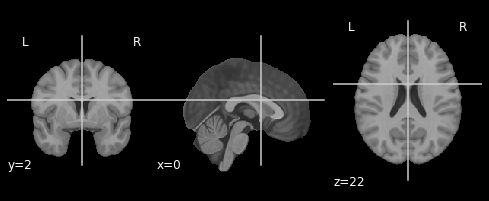

In [61]:
print('Path to MNI152 template: %r' % MNI152_FILE_PATH)
plotting.plot_anat(MNI152_FILE_PATH)

Let's center on the left auditory cortex (Heschl Gyrus)

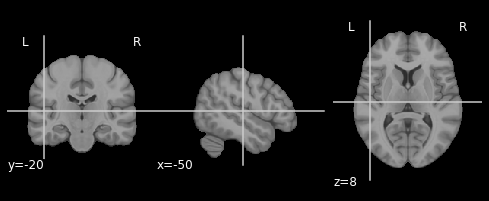

In [62]:
auditory_cortex_coords = (-50, -20, 8)   # coordinates in MNI space
plotting.plot_anat(MNI152_FILE_PATH, cut_coords=auditory_cortex_coords)

Simple image manipulation: smoothing
-------------------------------------

Let's use an image-smoothing function from nilearn:
:func:`nilearn.image.smooth_img`: https://nilearn.github.io/modules/generated/nilearn.image.smooth_img.html




In [63]:
smooth_anat_img = image.smooth_img(MNI152_FILE_PATH, fwhm=16)

# While we are giving a file name as input, the function returns
# an in-memory object:
smooth_anat_img

This is an in-memory object. We can pass it to nilearn function, for
instance to look at it



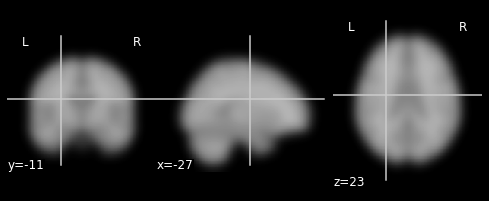

In [64]:
plotting.plot_anat(smooth_anat_img)

## Plot fMRI data

### Load the data

In [65]:
subj_data1 = fetch_spm_auditory()

A functional run contains a series of ### list the MRI (T2*) scans

In [66]:
subj_data1.func


['/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
 '/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_016.img',
 '/home/cp98

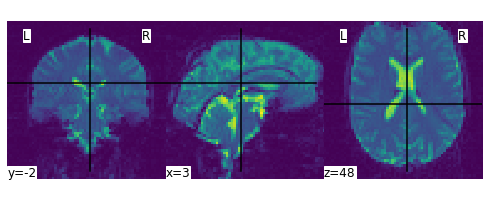

In [67]:
plotting.plot_img(subj_data1.func[0])

### Plot the timecourse of MRI signal in a voxel


To extract data inside a region of interest, for example a sphere centered on the auditory cortex, we need to create a _masker_.  

Read <https://nilearn.github.io/manipulating_images/masker_objects.html>

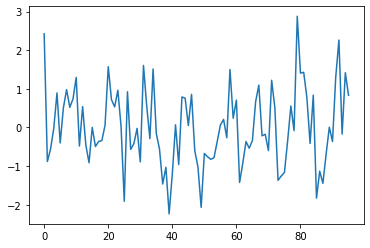

In [68]:
from nilearn import maskers

auditory_cortex_coords = (-46, -3, 40)  # in subject's native space

auditory_cortex_masker = maskers.NiftiSpheresMasker([auditory_cortex_coords], radius=3, t_r=7,  
                                                    detrend=True, standardize=True)

signal = auditory_cortex_masker.fit_transform(subj_data1.func)

plt.plot(signal)
plt.show()

In [69]:
??maskers.NiftiSpheresMasker

### compute correlations between this region and other brain voxels

In [70]:
brain_masker = maskers.NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True, t_r=7,
    memory='nilearn_cache', memory_level=1, verbose=0)

In [71]:
brain_time_series = brain_masker.fit_transform(subj_data1.func)

In [72]:
brain_time_series.shape

(96, 262073)

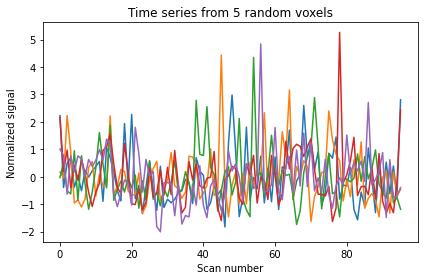

In [73]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

Let's compute the correlations between the auditory signal and each voxel's signal

In [74]:
import numpy as np

auditory_to_voxel_correlations = (np.dot(brain_time_series.T, signal) / signal.shape[0])

print("Seed-to-voxel correlation shape: (%s, %s)" %
      auditory_to_voxel_correlations.shape)
print("Seed-to-voxel correlation: min = %.3f; max = %.3f" % (
       auditory_to_voxel_correlations.min(), auditory_to_voxel_correlations.max()))

Seed-to-voxel correlation shape: (262073, 1)
Seed-to-voxel correlation: min = -0.445; max = 0.825


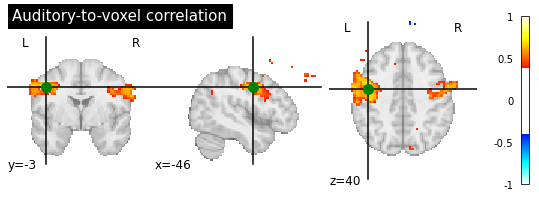

In [75]:
auditory_to_voxel_correlations_img = brain_masker.inverse_transform(auditory_to_voxel_correlations.T)
display = plotting.plot_stat_map(auditory_to_voxel_correlations_img,
                                 threshold=0.4, 
                                 vmax=1,
                                 cut_coords=auditory_cortex_coords,
                                 title="Auditory-to-voxel correlation"
                                 )
display.add_markers(marker_coords=[auditory_cortex_coords], marker_color='g', marker_size=100)

But wait, there is problem: activations are outside of the brain!

This is because the anatomical background is in the MNI space but we ran the analysis in the  space of acquisition (there was no normalization)

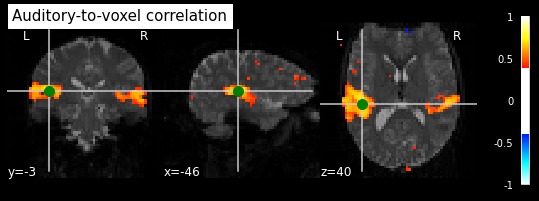

In [77]:
mean_image = mean_img(subj_data1.func)
display = plotting.plot_stat_map(auditory_to_voxel_correlations_img,
                                 threshold=0.4, 
                                 vmax=1,
                                 cut_coords=auditory_cortex_coords,
                                 bg_img=mean_image,
                                 title="Auditory-to-voxel correlation"
                                 )
display.add_markers(marker_coords=[auditory_cortex_coords], marker_color='g', marker_size=100)

## Let's correlate with predictor obtained from the stimulation

In [78]:
subj_data1.events

'/home/cp983411/nilearn_data/spm_auditory/sub001/fM00223/fM00223_events.tsv'

In [79]:
events = pd.read_table(subj_data1.events)
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


Let us create and estimate a ``FirstLevelModel`` object, that will generate the *design  matrix* using the  information provided by the ``events`` object.


Parameters of the first-level model:

 * t_r=7(s) is the time of repetition of acquisitions
 * noise_model='ar1' specifies the noise covariance model: a lag-1 dependence
 * standardize=False means that we do not want to rescale the time series to mean 0, variance 1
 * hrf_model='spm' means that we rely on the SPM "canonical hrf" model (without time or dispersion derivatives)
 * drift_model='cosine' means that we model the signal drifts as slow oscillating time functions
 * high_pass=0.01(Hz) defines the cutoff frequency (inverse of the time period).



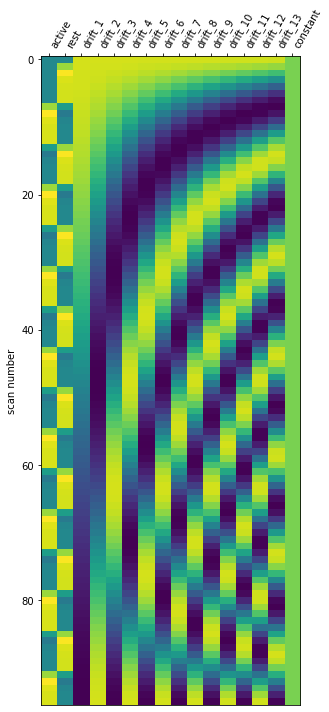

In [80]:

fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

fmri_imgs = concat_imgs(subj_data1.func)  # convert 3D to 4D
fmri_glm = fmri_glm.fit(fmri_imgs, events)

design_matrix = fmri_glm.design_matrices_[0]
plotting.plot_design_matrix(design_matrix)
plt.show()


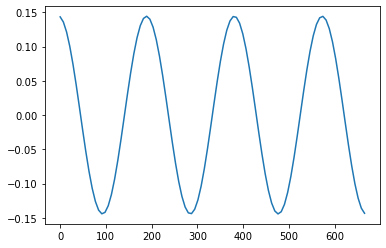

In [81]:
plt.plot(design_matrix["drift_7"])

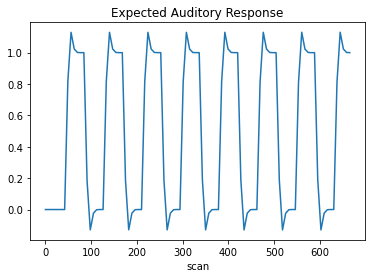

In [82]:
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

To access the estimated coefficients (Betas of the :term:`GLM` model), we
create `conditions` with a single '1' in the relevant column:

In [83]:
from numpy import array
conditions = {
    'active': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.]),
    'rest':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.]),
}

To compare the two conditions 'active' and 'rest' we define a :term:`contrast`:

[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


<AxesSubplot:label='conditions'>

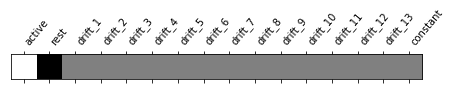

In [84]:
active_minus_rest = conditions['active'] - conditions['rest']
print(active_minus_rest)
plotting.plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)


We compute the estimated effect ("arbitrary" units).

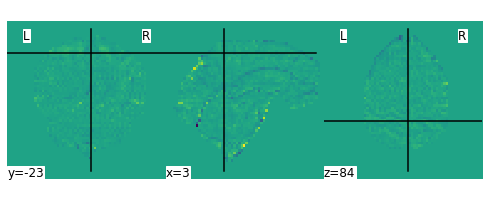

In [85]:
eff_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_size')
plotting.plot_img(eff_map)


In order to get statistical significance, we form a t-statistic, and
directly convert it into z-scale. The z-scale means that the values
are scaled to match a standard Gaussian distribution (mean=0,
variance=1), across voxels, if there were no effects in the data.

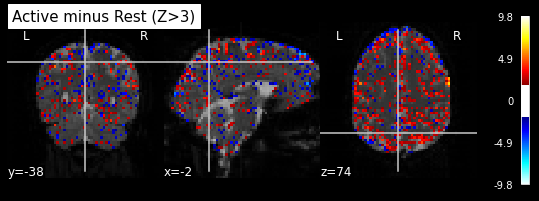

In [91]:
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

plotting.plot_stat_map(z_map, bg_img=mean_image, threshold=1.96,
                      display_mode='ortho', black_bg=True,
                      title='Active minus Rest (Z>3)')

In statistical significance testing, one should worry about the
statistical validity of the procedure: here we used an arbitrary
 threshold of 2.0 but the threshold should provide some guarantees on
 the risk of false detections (aka type-1 errors in statistics).
 One suggestion is to control the _false positive rate_ (denoted by
 alpha) at a certain level, e.g. 0.001: this means that there is 0.1% chance
 of declaring an inactive voxel, active.

Uncorrected p<0.001 threshold: 3.291


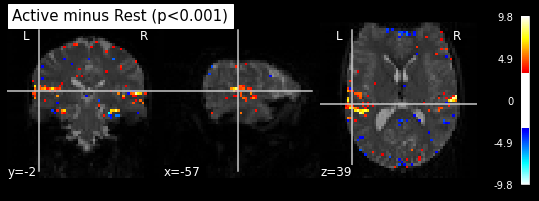

In [92]:
_, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plotting.plot_stat_map(z_map, bg_img=mean_image, threshold=threshold,
              display_mode='ortho', black_bg=True,
              title='Active minus Rest (p<0.001)')



The problem is that with this you expect 0.001 * n_voxels to show up
while they're not active --- tens to hundreds of voxels. A more
conservative solution is to control the family wise error rate,
i.e. the probability of making only one false detection, say at
5%. For that we use the so-called Bonferroni correction.

Bonferroni-corrected, p<0.05 threshold: 4.934


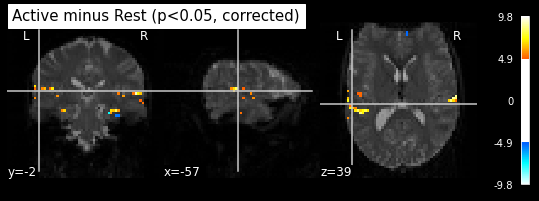

In [88]:
_, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(z_map, bg_img=mean_image, threshold=threshold,
              display_mode='ortho', black_bg=True,
              title='Active minus Rest (p<0.05, corrected)')


This is quite conservative.  A popular alternative is to
control the expected proportion of false discoveries among detections. This is called the _False
discovery rate_.

False Discovery rate = 0.05 threshold: 2.904


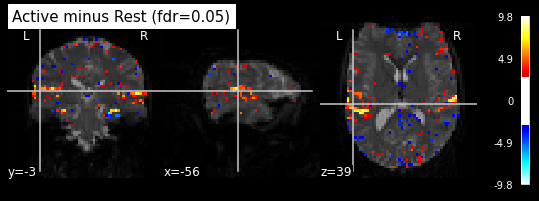

In [89]:
_, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(z_map, bg_img=mean_image, threshold=threshold,
              display_mode='ortho', black_bg=True,
              title='Active minus Rest (fdr=0.05)')
plt.show()

## Group analysis

Read and execute  <https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html>

## Multivariate decoding analysis

Haxby, J., Gobbini, M., Furey, M., Ishai, A., Schouten, J., and Pietrini, P. (2001). [Distributed and overlapping representations of faces and objects in ventral temporal cortex](http://haxbylab.dartmouth.edu/publications/HGF+01.pdf). Science 293, 2425–2430.  

This is a block-design fMRI dataset from a study on face and object representation in human ventral temporal cortex. In each run, the subject passively viewed greyscale images of eight object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval. Full-brain fMRI data were recorded with a volume repetition time of 2.5s. 

To decode the category of the stimuli from the pattern of activations in the ventral visual cortex, 
go to <https://nilearn.github.io/stable/auto_examples/02_decoding/plot_haxby_full_analysis.html>